In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df = pd.read_csv('house_price_regression_dataset.csv')

In [ ]:
pd.options.display.float_format = '{:,.2f}'.format

In [ ]:
df.head()

,Square_Footage,Num_Bedrooms,Num_Bathrooms,Year_Built,Lot_Size,Garage_Size,Neighborhood_Quality,House_Price
0,1360,2,1,1981,0.60,0,5,"262,382.85"
1,4272,3,3,2016,4.75,1,6,"985,260.85"
2,3592,1,2,2016,3.63,0,9,"777,977.39"
3,966,1,2,1977,2.73,1,8,"229,698.92"
4,4926,2,1,1993,4.70,0,8,"1,041,740.86"


In [ ]:
X = df.drop('House_Price', axis = 1)
y = df['House_Price']

## Feature Engineering

#### Creating a new feature using the existing year as year has so many values.

In [ ]:
def transform_year(year):
  if year >= 1950 and year < 1970:
    return 'Before 1970'
  elif year >= 1970 and year < 2000:
    return 'Before 2000'
  elif year >= 2000:
    return 'After 2000'
  else:
    return 'Others'

X['Year_Ranges'] = X['Year_Built'].apply(transform_year)
X = X.drop('Year_Built', axis = 1)

### Performing Ordinal Encoding on the Year Ranges column

In [ ]:
from sklearn.preprocessing import OrdinalEncoder

oe = OrdinalEncoder(categories = [['Before 1970', 'Before 2000', 'After 2000']])

oe.fit(X[['Year_Ranges']])

X['Year_Ranges'] = oe.transform(X[['Year_Ranges']])

In [ ]:
X.columns

Index(['Square_Footage', 'Num_Bedrooms', 'Num_Bathrooms', 'Lot_Size',
       'Garage_Size', 'Neighborhood_Quality', 'Year_Ranges'],
      dtype='object')

In [ ]:
X.head()

,Square_Footage,Num_Bedrooms,Num_Bathrooms,Lot_Size,Garage_Size,Neighborhood_Quality,Year_Ranges
0,1360,2,1,0.60,0,5,1.00
1,4272,3,3,4.75,1,6,2.00
2,3592,1,2,3.63,0,9,2.00
3,966,1,2,2.73,1,8,1.00
4,4926,2,1,4.70,0,8,1.00


In [ ]:
from sklearn.preprocessing import StandardScaler

def scaleColumns(df, columns):

  tempdf = df.copy()

  for column in columns:

    sc = StandardScaler()

    tempdf[column] = sc.fit_transform(tempdf[[column]])

  return tempdf

In [ ]:
scaleddf = scaleColumns(X,['Square_Footage', 'Num_Bedrooms', 'Num_Bathrooms', 'Lot_Size',
       'Garage_Size', 'Neighborhood_Quality', 'Year_Ranges'])

## Feature Selection

### 1. Correlation Analysis

<Axes: >

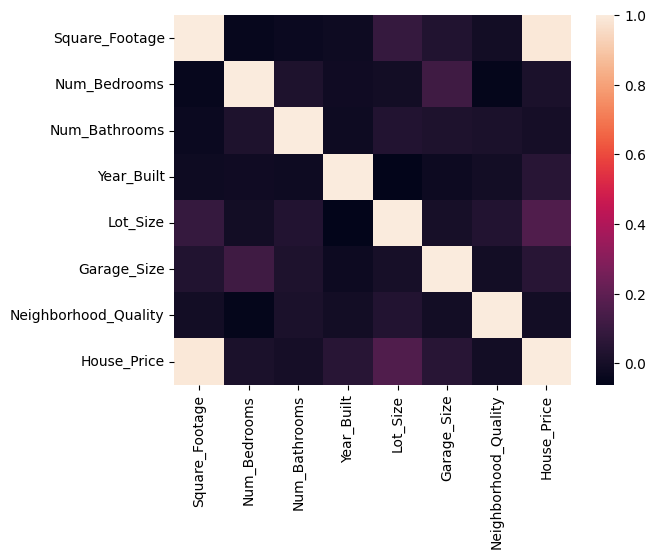

In [ ]:
sns.heatmap(df.corr())

In [ ]:
fi_df1 = df.corr()[['House_Price']].drop('House_Price')
fi_df1['feature'] = df.columns.drop('House_Price')

### Technique 2 - Random Forest Feature Importance

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf_label = RandomForestRegressor(n_estimators=100, random_state=42)
rf_label.fit(X, y)

fi_df2 = pd.DataFrame({
    'feature': X.columns,
    'rf_importance': rf_label.feature_importances_
}).sort_values(by='rf_importance', ascending=False)

### Technique 3 - Gradient Boosting Feature importances

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

gb_label = GradientBoostingRegressor()
gb_label.fit(X, y)

fi_df3 = pd.DataFrame({
    'feature': X.columns,
    'gb_importance': gb_label.feature_importances_
}).sort_values(by='gb_importance', ascending=False)

fi_df3

,feature,gb_importance
0,Square_Footage,0.99
3,Lot_Size,0.01
6,Year_Ranges,0.00
1,Num_Bedrooms,0.00
2,Num_Bathrooms,0.00
4,Garage_Size,0.00
5,Neighborhood_Quality,0.00


### Technique 4 - Permutation Importance

In [ ]:
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split

X_train_label, X_test_label, y_train_label, y_test_label = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest regressor on label encoded data
rf_label = RandomForestRegressor(n_estimators=100, random_state=42)
rf_label.fit(X_train_label, y_train_label)

# Calculate Permutation Importance
perm_importance = permutation_importance(rf_label, X_test_label, y_test_label, n_repeats=30, random_state=42)

# Organize results into a DataFrame
fi_df4 = pd.DataFrame({
    'feature': X.columns,
    'permutation_importance': perm_importance.importances_mean
}).sort_values(by='permutation_importance', ascending=False)

fi_df4

,feature,permutation_importance
0,Square_Footage,2.03
3,Lot_Size,0.01
6,Year_Ranges,0.01
1,Num_Bedrooms,0.00
2,Num_Bathrooms,0.00
4,Garage_Size,0.00
5,Neighborhood_Quality,-0.00


### Technique 5 - LASSO

In [ ]:
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler


# Train a LASSO regression model
# We'll use a relatively small value for alpha (the regularization strength) for demonstration purposes
lasso = Lasso(alpha=0.01, random_state=42)
lasso.fit(X, y)

# Extract coefficients
fi_df5 = pd.DataFrame({
    'feature': X.columns,
    'lasso_coeff': lasso.coef_
}).sort_values(by='lasso_coeff', ascending=False)

fi_df5

,feature,lasso_coeff
6,Year_Ranges,"25,419.56"
3,Lot_Size,"14,837.00"
1,Num_Bedrooms,"9,991.34"
2,Num_Bathrooms,"8,501.58"
4,Garage_Size,"4,797.79"
0,Square_Footage,199.71
5,Neighborhood_Quality,85.50


### Technique 6 - RFE

In [ ]:
from sklearn.feature_selection import RFE

# Initialize the base estimator
estimator = RandomForestRegressor()

# Apply RFE on the label-encoded and standardized training data
selector_label = RFE(estimator, n_features_to_select=X.shape[1], step=1)
selector_label = selector_label.fit(X, y)

# Get the selected features based on RFE
selected_features = X.columns[selector_label.support_]

# Extract the coefficients for the selected features from the underlying linear regression model
selected_coefficients = selector_label.estimator_.feature_importances_

# Organize the results into a DataFrame
fi_df6 = pd.DataFrame({
    'feature': selected_features,
    'rfe_score': selected_coefficients
}).sort_values(by='rfe_score', ascending=False)

fi_df6

,feature,rfe_score
0,Square_Footage,0.99
3,Lot_Size,0.01
6,Year_Ranges,0.00
1,Num_Bedrooms,0.00
5,Neighborhood_Quality,0.00
2,Num_Bathrooms,0.00
4,Garage_Size,0.00


### Technique 7 - Linear Regression Weights

In [ ]:
# Train a linear regression model on the label-encoded and standardized training data
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X, y)

# Extract coefficients
fi_df7 = pd.DataFrame({
    'feature': X.columns,
    'reg_coeffs': lin_reg.coef_[0]
}).sort_values(by='reg_coeffs', ascending=False)

fi_df7

,feature,reg_coeffs
0,Square_Footage,199.71
1,Num_Bedrooms,199.71
2,Num_Bathrooms,199.71
3,Lot_Size,199.71
4,Garage_Size,199.71
5,Neighborhood_Quality,199.71
6,Year_Ranges,199.71


### Technique 8 - SHAP

In [ ]:
import shap

# Compute SHAP values using the trained Random Forest model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X, y)

explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X)

# Summing the absolute SHAP values across all samples to get an overall measure of feature importance
shap_sum = np.abs(shap_values).mean(axis=0)

shap_values

array([[-2.93620650e+05, -8.82725141e+03, -2.70309285e+03, ...,
        -3.36530999e+03, -1.17671052e+03, -2.18685318e+03],
       [ 2.96816151e+05, -5.68110616e+02,  2.94329729e+03, ...,
        -3.96072578e+02,  2.00870803e+03,  1.73985758e+04],
       [ 1.43397647e+05, -8.27022094e+03,  5.76414052e+01, ...,
        -1.40943259e+03, -1.19736068e+03,  1.28244672e+04],
       ...,
       [-4.29928932e+04,  3.99028062e+03, -1.32462529e+03, ...,
        -2.39397251e+03, -7.98749246e+02, -1.19959735e+04],
       [ 3.67635721e+05,  7.74350073e+03, -1.01384241e+03, ...,
        -2.05300912e+03,  1.25667043e+02, -1.62241941e+04],
       [ 9.75491593e+04,  3.97085411e+03,  5.75331136e+02, ...,
         2.01448279e+03,  1.93391308e+03, -5.19618725e+02]])

In [ ]:
fi_df8 = pd.DataFrame({
    'feature': X.columns,
    'SHAP_score': np.abs(shap_values).mean(axis=0)
}).sort_values(by='SHAP_score', ascending=False)

fi_df8

,feature,SHAP_score
0,Square_Footage,"216,735.23"
3,Lot_Size,"13,258.62"
6,Year_Ranges,"8,839.52"
1,Num_Bedrooms,"6,121.83"
2,Num_Bathrooms,"1,911.43"
4,Garage_Size,"1,215.34"
5,Neighborhood_Quality,703.29


In [ ]:
final_fi_df = fi_df1.merge(fi_df2,on='feature').merge(fi_df3,on='feature').merge(fi_df4,on='feature').merge(fi_df5,on='feature').merge(fi_df6,on='feature').merge(fi_df7,on='feature').merge(fi_df8,on='feature').set_index('feature')


In [ ]:
final_fi_df

,House_Price,rf_importance,gb_importance,permutation_importance,lasso_coeff,rfe_score,reg_coeffs,SHAP_score
feature,,,,,,,,
Square_Footage,0.99,0.99,0.99,2.03,199.71,0.99,199.71,"216,735.23"
Num_Bedrooms,0.01,0.00,0.00,0.00,"9,991.34",0.00,199.71,"6,121.83"
Num_Bathrooms,-0.00,0.00,0.00,0.00,"8,501.58",0.00,199.71,"1,911.43"
Lot_Size,0.16,0.01,0.01,0.01,"14,837.00",0.01,199.71,"13,258.62"
Garage_Size,0.05,0.00,0.00,0.00,"4,797.79",0.00,199.71,"1,215.34"
Neighborhood_Quality,-0.01,0.00,0.00,-0.00,85.50,0.00,199.71,703.29


In [ ]:
final_fi_df = final_fi_df.divide(final_fi_df.sum(axis=0), axis=1)

In [ ]:
final_fi_df[['rf_importance','gb_importance','permutation_importance','rfe_score','SHAP_score']].mean(axis=1).sort_values(ascending=False)


,0
feature,
Square_Footage,0.97
Lot_Size,0.02
Num_Bedrooms,0.01
Num_Bathrooms,0.00
Garage_Size,0.00
Neighborhood_Quality,0.00


In [ ]:
# with all the cols
from sklearn.model_selection import cross_val_score

rf = RandomForestRegressor(n_estimators=100, random_state=42)

scores = cross_val_score(rf, X, y, cv=5, scoring='r2')

In [ ]:
scores.mean()

np.float64(0.9920161266658246)

In [ ]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)

scores = cross_val_score(rf, X.drop(columns=['Num_Bathrooms', 'Garage_Size', 'Neighborhood_Quality']), y, cv=5, scoring='r2')

In [ ]:
scores.mean()

np.float64(0.9923066738541995)

In [ ]:
X.head()

,Square_Footage,Num_Bedrooms,Num_Bathrooms,Lot_Size,Garage_Size,Neighborhood_Quality,Year_Ranges
0,1360,2,1,0.60,0,5,1.00
1,4272,3,3,4.75,1,6,2.00
2,3592,1,2,3.63,0,9,2.00
3,966,1,2,2.73,1,8,1.00
4,4926,2,1,4.70,0,8,1.00


In [ ]:
X['House_Price'] = y

In [ ]:
X.head()

,Square_Footage,Num_Bedrooms,Num_Bathrooms,Lot_Size,Garage_Size,Neighborhood_Quality,Year_Ranges,House_Price
0,1360,2,1,0.60,0,5,1.00,"262,382.85"
1,4272,3,3,4.75,1,6,2.00,"985,260.85"
2,3592,1,2,3.63,0,9,2.00,"777,977.39"
3,966,1,2,2.73,1,8,1.00,"229,698.92"
4,4926,2,1,4.70,0,8,1.00,"1,041,740.86"


In [ ]:
X = X.drop(columns = ['Num_Bathrooms', 'Num_Bathrooms', 'Garage_Size', 'Neighborhood_Quality', 'Year_Ranges'])

In [ ]:
X.to_csv('House_Price_Prediction_After_Feature_Selection.csv', index = False)